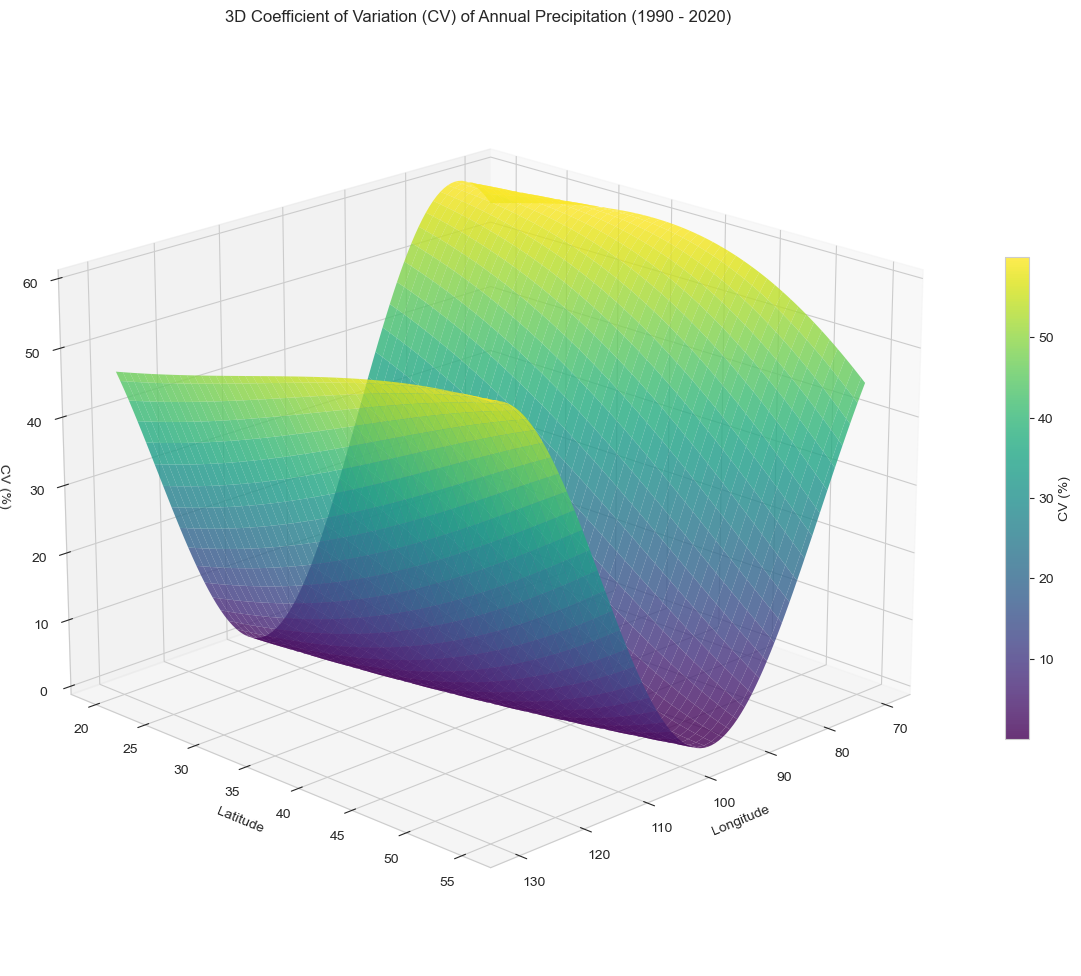

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# 1. 创建数据
longitude = np.linspace(70, 130, 100)
latitude = np.linspace(20, 55, 100)
X, Y = np.meshgrid(longitude, latitude)
# 用函数模拟CV值，请替换为您的真实数据 `Z = your_cv_data`
Z = 30 * (np.sin(np.sqrt(X**2 + Y**2) * 0.1) + 1)

# 2. 创建画布和3D轴
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(projection='3d')

# 3. 绘制曲面
surf = ax.plot_surface(X, Y, Z, cmap=cm.viridis, linewidth=0, antialiased=True, alpha=0.8)

# 4. 添加颜色条
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=20, label='CV (%)')

# 5. 设置标签和标题
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('CV (%)')
ax.set_title('3D Coefficient of Variation (CV) of Annual Precipitation (1990 - 2020)')

# 6. 调整视角
ax.view_init(elev=20, azim=45)

# 7. 显示和保存
plt.tight_layout()
plt.savefig('3d_cv_plot.png', dpi=300)
plt.show()

# SVM向量机代码 散点图

Epoch [10/100], Train Loss: 0.1324, Val Loss: 0.1328
Epoch [20/100], Train Loss: 0.1350, Val Loss: 0.1317
Epoch [30/100], Train Loss: 0.1297, Val Loss: 0.1314
Epoch [40/100], Train Loss: 0.1307, Val Loss: 0.1318
Epoch [50/100], Train Loss: 0.1346, Val Loss: 0.1311
Epoch [60/100], Train Loss: 0.1277, Val Loss: 0.1303
Epoch [70/100], Train Loss: 0.1289, Val Loss: 0.1301
Epoch [80/100], Train Loss: 0.1344, Val Loss: 0.1299
Epoch [90/100], Train Loss: 0.1323, Val Loss: 0.1297
Epoch [100/100], Train Loss: 0.1320, Val Loss: 0.1299

集成模型均方误差(MSE): 0.0287

集成误差(RMSE): 0.0287
集成模型决定系数(R²): 0.8862


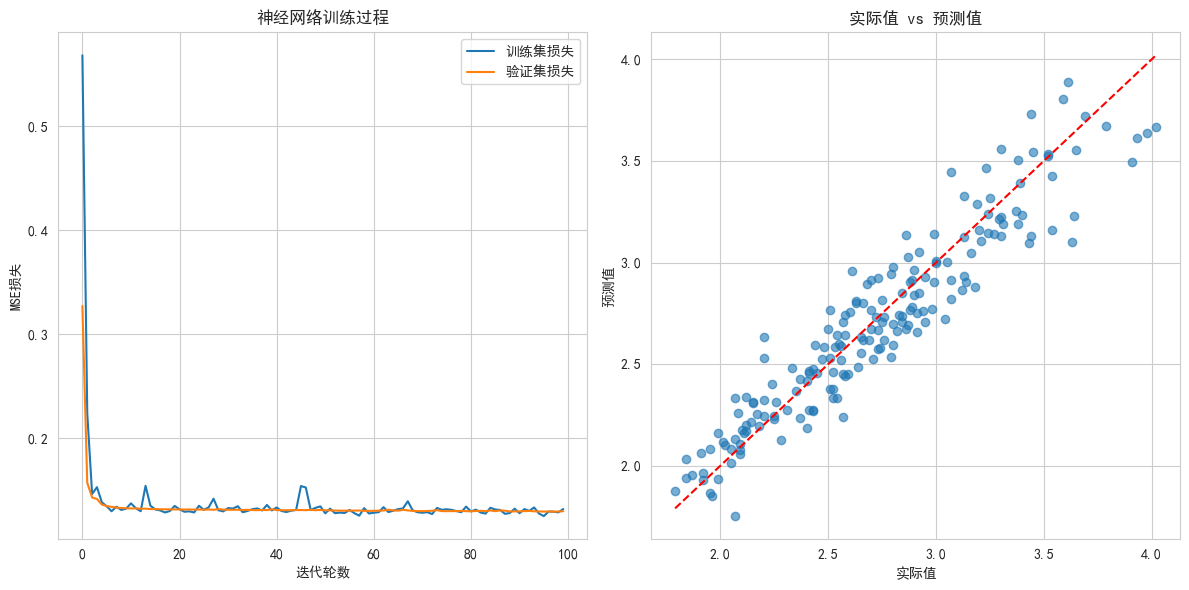

In [2]:
import pandas as pd
from matplotlib import rcParams
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

rcParams["font.sans-serif"] = ["SimHei"]  # 指定中文字体
rcParams["axes.unicode_minus"] = False  # 解决负号显示问题
df = pd.read_excel('核桃仁表型信息_重新标定.xlsx')
df = df.drop('filename', axis=1)
X, Y = df.drop('g', axis=1), df['g']
X = X.drop('error', axis=1)
X.shape
# 1. 生成示例数据集
X, y = X, Y

# 2. 数据预处理
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# 3. 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.3, random_state=42
)

# 4. 训练SVR模型
svr_model = SVR(
    kernel='rbf',
    C=1.0,
    epsilon=0.1,
    gamma='scale'
)
svr_model.fit(X_train, y_train)

# 5. 使用SVR进行预测（输出作为神经网络输入）
train_svr_pred = svr_model.predict(X_train)
test_svr_pred = svr_model.predict(X_test)

# 将SVR输出转换为PyTorch张量
X_train_nn = torch.tensor(train_svr_pred.reshape(-1, 1), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_nn = torch.tensor(test_svr_pred.reshape(-1, 1), dtype=torch.float32)

# 创建数据加载器
train_dataset = TensorDataset(X_train_nn, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


# 6. 构建PyTorch神经网络模型
class RegressionNN(nn.Module):
    def __init__(self):
        super(RegressionNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.layers(x)


model = RegressionNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 7. 训练神经网络
train_losses = []
val_losses = []

for epoch in range(100):
    # 训练模式
    model.train()
    epoch_loss = 0.0

    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # 计算平均训练损失
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # 验证模式
    model.eval()
    with torch.no_grad():
        val_preds = model(X_train_nn)
        val_loss = criterion(val_preds, y_train_tensor.unsqueeze(1))
        val_losses.append(val_loss.item())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/100], Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss.item():.4f}')

# 8. 使用集成模型进行预测
model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_test_nn).squeeze().numpy()

# 9. 反标准化得到最终预测结果
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# 10. 评估模型性能
mse = mean_squared_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred)  # 直接输出RMSE
r2 = r2_score(y_true, y_pred)
print(f"\n集成模型均方误差(MSE): {mse:.4f}")
print(f"\n集成误差(RMSE): {rmse:.4f}")
print(f"集成模型决定系数(R²): {r2:.4f}")

# 11. 可视化结果
plt.figure(figsize=(12, 6))

# 绘制训练过程损失曲线
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='训练集损失')
plt.plot(val_losses, label='验证集损失')
plt.title('神经网络训练过程')
plt.ylabel('MSE损失')
plt.xlabel('迭代轮数')
plt.legend()

# 绘制实际值 vs 预测值
plt.subplot(1, 2, 2)
plt.scatter(y_true, y_pred, alpha=0.6)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
plt.title('实际值 vs 预测值')
plt.xlabel('实际值')
plt.ylabel('预测值')

plt.tight_layout()
plt.show()

# 残差图 索引图 散点图 SVR

               SVR模型性能评估                
均方误差(MSE): 	0.0283
均方根误差(RMSE): 	0.0283
决定系数(R²): 	0.8878


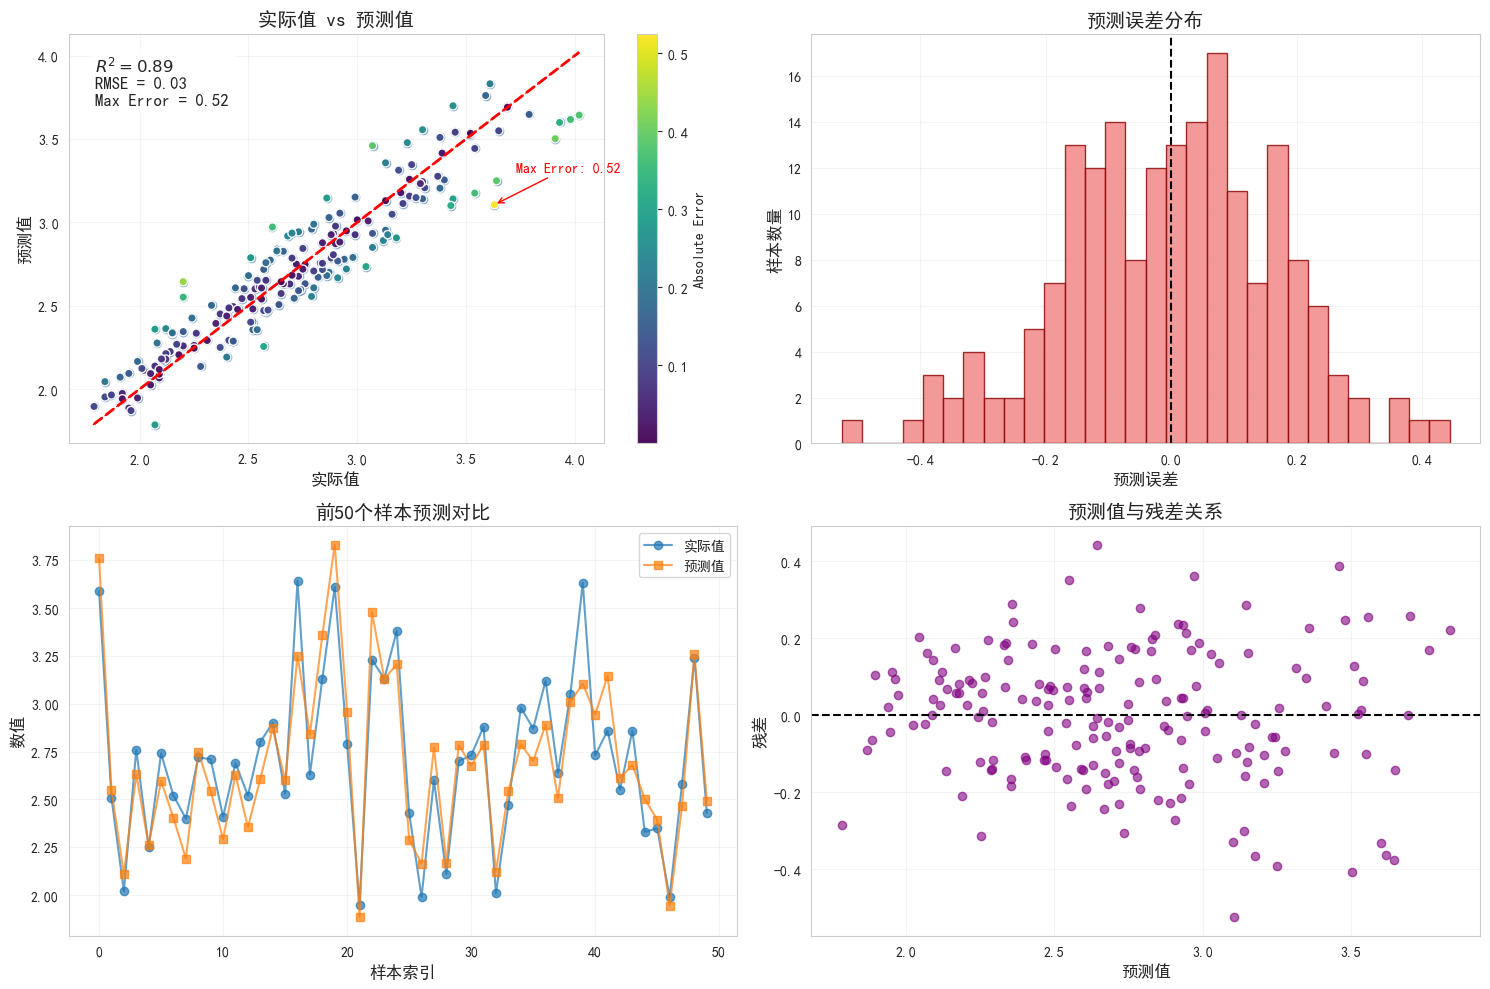

In [3]:
from matplotlib import rcParams
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# 设置中文字体
rcParams["font.sans-serif"] = ["SimHei"]
rcParams["axes.unicode_minus"] = False

# 1. 数据预处理
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# 2. 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.3, random_state=42
)

# 3. 训练SVR模型[1,2](@ref)
svr_model = SVR(
    kernel='rbf',  # 使用径向基函数核处理非线性关系[4](@ref)
    C=1.0,  # 正则化参数，平衡模型复杂度与误差
    epsilon=0.1,  # 不敏感区域宽度，控制对噪声的容忍度[4](@ref)
    gamma='scale'  # 自动确定核函数影响范围
)
svr_model.fit(X_train, y_train)

# 4. 模型预测[1](@ref)
# 在标准化空间进行预测
y_pred_scaled = svr_model.predict(X_test)

# 5. 反标准化得到最终结果[1](@ref)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# 6. 模型评估[2,5](@ref)
mse = mean_squared_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred)  # 直接计算RMSE
r2 = r2_score(y_true, y_pred)

print("=" * 50)
print(f"{'SVR模型性能评估':^40}")
print("=" * 50)
print(f"均方误差(MSE): \t{mse:.4f}")
print(f"均方根误差(RMSE): \t{rmse:.4f}")
print(f"决定系数(R²): \t{r2:.4f}")
print("=" * 50)

# 7. 可视化结果[1,8](@ref)
plt.figure(figsize=(15, 10))

# 7.1 预测值 vs 实际值散点图
plt.subplot(2, 2, 1)
plt.scatter(y_true, y_pred, alpha=0.6, color='steelblue')
sc = plt.scatter(y_true, y_pred, c=np.abs(y_true - y_pred), cmap='viridis', alpha=0.95, edgecolors='w')
plt.colorbar(sc, label='Absolute Error')
# 绘制对角线
min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=1)
abs_errors = np.abs(y_true - y_pred)
max_error = np.max(abs_errors)
max_idx = np.argmax(abs_errors)  # 获取最大误差点的索引

# 标注最大误差点
plt.annotate(f'Max Error: {max_error:.2f}',
             xy=(y_true[max_idx], y_pred[max_idx]),
             xytext=(y_true[max_idx] + 0.1, y_pred[max_idx] + 0.2),
             arrowprops=dict(arrowstyle='->', color='red'),
             fontsize=10,
             color='red')
# 添加指标文本
textstr = '\n'.join((
    fr'$R^2 = {r2:.2f}$',
    fr'RMSE = {rmse:.2f}',
    fr'Max Error = {max_error:.2f}'))
plt.gca().text(0.05, 0.95, textstr, transform=plt.gca().transAxes,
               fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))

plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)],
         'r--', linewidth=2)
plt.title('实际值 vs 预测值', fontsize=14)
plt.xlabel('实际值', fontsize=12)
plt.ylabel('预测值', fontsize=12)
plt.grid(alpha=0.2)

# 7.2 预测误差分布直方图
plt.subplot(2, 2, 2)
errors = y_pred - y_true
plt.hist(errors, bins=30, color='lightcoral', edgecolor='darkred', alpha=0.8)
plt.axvline(x=0, color='k', linestyle='--')
plt.title('预测误差分布', fontsize=14)
plt.xlabel('预测误差', fontsize=12)
plt.ylabel('样本数量', fontsize=12)
plt.grid(alpha=0.2)

# 7.3 特征重要性可视化（如适用）
if hasattr(svr_model, 'coef_') and svr_model.kernel == 'linear':
    plt.subplot(2, 2, 3)
    feature_importance = np.abs(svr_model.coef_[0])
    sorted_idx = np.argsort(feature_importance)
    plt.barh(range(len(feature_importance)),
             feature_importance[sorted_idx],
             color='mediumseagreen')
    plt.yticks(range(len(feature_importance)),
               np.array(X.columns)[sorted_idx] if hasattr(X, 'columns') else range(len(feature_importance)))
    plt.title('特征重要性', fontsize=14)
    plt.xlabel('重要性系数', fontsize=12)
    plt.grid(alpha=0.2, axis='x')
else:
    # 若无法获取特征重要性，显示预测值与实际值对比曲线
    plt.subplot(2, 2, 3)
    plt.plot(y_true[:50], 'o-', label='实际值', alpha=0.7)
    plt.plot(y_pred[:50], 's-', label='预测值', alpha=0.7)
    plt.title('前50个样本预测对比', fontsize=14)
    plt.xlabel('样本索引', fontsize=12)
    plt.ylabel('数值', fontsize=12)
    plt.legend()
    plt.grid(alpha=0.2)

# 7.4 残差图
plt.subplot(2, 2, 4)
plt.scatter(y_pred, errors, alpha=0.6, color='purple')
plt.axhline(y=0, color='k', linestyle='--')
plt.title('预测值与残差关系', fontsize=14)
plt.xlabel('预测值', fontsize=12)
plt.ylabel('残差', fontsize=12)
plt.grid(alpha=0.2)

plt.tight_layout()
plt.show()

# 频次图

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1461 non-null   object 
 1   precipitation  1461 non-null   float64
 2   temp_max       1461 non-null   float64
 3   temp_min       1461 non-null   float64
 4   wind           1461 non-null   float64
 5   weather        1461 non-null   object 
dtypes: float64(4), object(2)
memory usage: 68.6+ KB


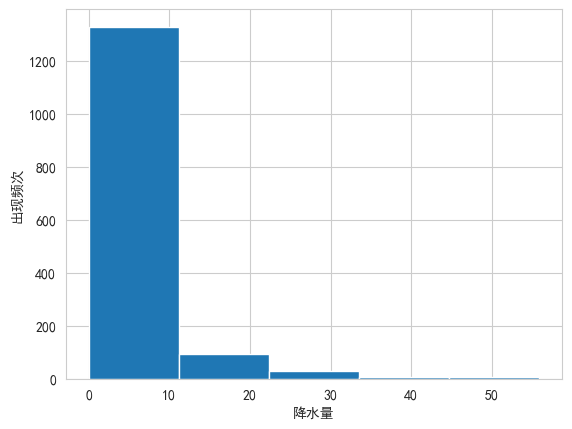

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams["font.sans-serif"] = ["SimHei"]  # 指定中文字体
rcParams["axes.unicode_minus"] = False  # 解决负号显示问题

df = pd.read_csv("data/weather.csv")
df.info()  # 查看数据集信息
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
ax1.hist(df["precipitation"], bins=5)  # 绘制直方图，将降水量均匀分为5组
ax1.set_xlabel("降水量")
ax1.set_ylabel("出现频次")
plt.show()


# 双变量散点图

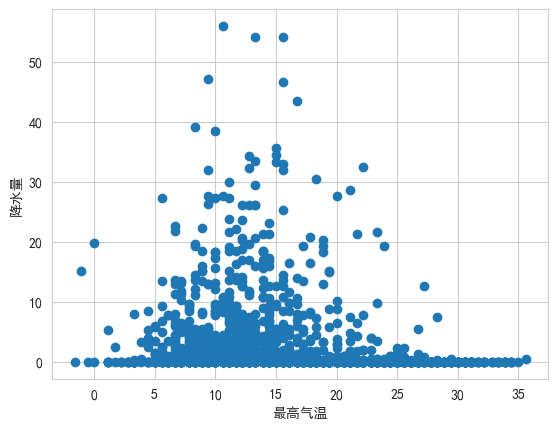

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams["font.sans-serif"] = ["SimHei"]  # 指定中文字体
rcParams["axes.unicode_minus"] = False  # 解决负号显示问题

df = pd.read_csv("data/weather.csv")
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(df["temp_max"], df["precipitation"])  # 绘制散点图，横轴为最高气温，纵轴为降水量
ax1.set_xlabel("最高气温")
ax1.set_ylabel("降水量")
plt.show()


# 多变量散点图

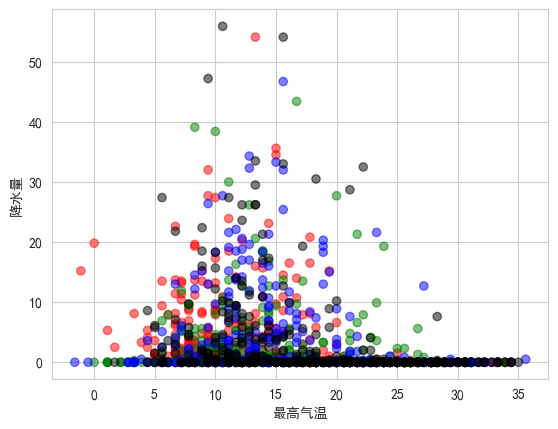

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams["font.sans-serif"] = ["SimHei"]  # 指定中文字体
rcParams["axes.unicode_minus"] = False  # 解决负号显示问题

def year_color(x):
    # 添加一列，为不同年份的数据添加不同的颜色
    match x.year:
        case 2012:
            return "r"
        case 2013:
            return "g"
        case 2014:
            return "b"
        case 2015:
            return "k"

df = pd.read_csv("data/weather.csv")
df["date"] = pd.to_datetime(df["date"])
df["color"] = df["date"].apply(year_color)
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
# 绘制散点图，横轴为最高气温，纵轴为降水量
# c设置颜色,alpha设置透明度
ax1.scatter(df["temp_max"], df["precipitation"], c=df["color"], alpha=0.5)
ax1.set_xlabel("最高气温")
ax1.set_ylabel("降水量")
plt.show()



# 柱状图

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   person_id                400 non-null    int64  
 1   gender                   400 non-null    object 
 2   age                      400 non-null    int64  
 3   occupation               400 non-null    object 
 4   sleep_duration           400 non-null    float64
 5   sleep_quality            400 non-null    float64
 6   physical_activity_level  400 non-null    int64  
 7   stress_level             400 non-null    int64  
 8   bmi_category             400 non-null    object 
 9   blood_pressure           400 non-null    object 
 10  heart_rate               400 non-null    int64  
 11  daily_steps              400 non-null    int64  
 12  sleep_disorder           110 non-null    object 
dtypes: float64(2), int64(6), object(5)
memory usage: 40.8+ KB


<Axes: xlabel='sleep_duration'>

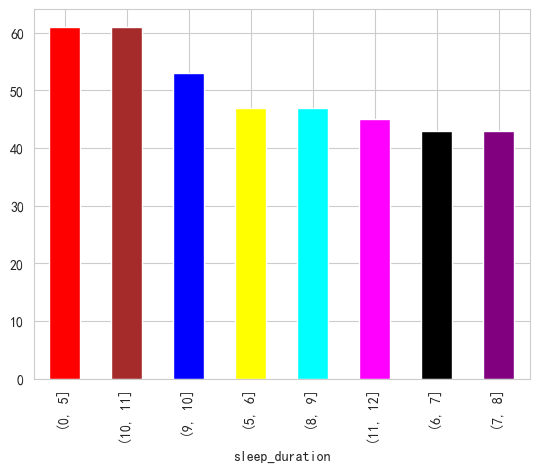

In [7]:
import pandas as pd

df = pd.read_csv("data/sleep.csv")
df.info()  # 查看数据集信息
pd.cut(df["sleep_duration"], [0, 5, 6, 7, 8, 9, 10, 11, 12]).value_counts().plot.bar(
    color=["red", "brown", "blue", "yellow", "cyan", "magenta", "black", "purple"]
)


# 折线图

<Axes: xlabel='sleep_duration'>

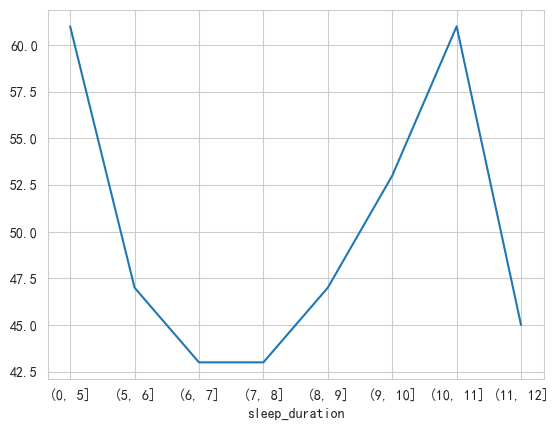

In [8]:
pd.cut(df["sleep_duration"], [0, 5, 6, 7, 8, 9, 10, 11, 12]).value_counts().sort_index().plot()

# 面积图

<Axes: xlabel='sleep_duration'>

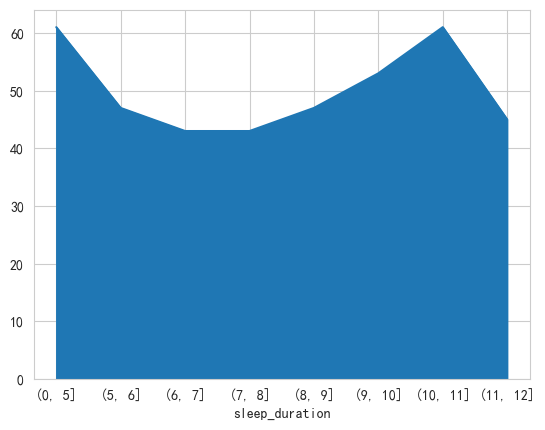

In [9]:
pd.cut(df["sleep_duration"], [0, 5, 6, 7, 8, 9, 10, 11, 12]).value_counts().sort_index().plot.area()

# 直方图

<Axes: ylabel='Frequency'>

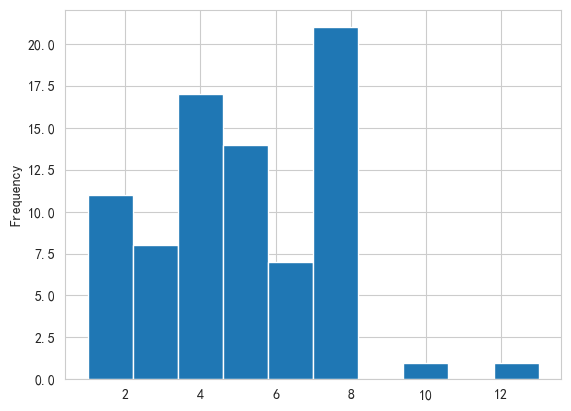

In [10]:
df["sleep_duration"].value_counts().plot.hist()

# 饼图

<Axes: ylabel='count'>

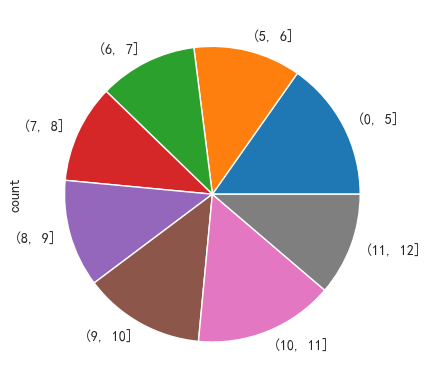

In [11]:
pd.cut(df["sleep_duration"], [0, 5, 6, 7, 8, 9, 10, 11, 12]).value_counts().sort_index().plot.pie()

# 蜂窝图

<Axes: xlabel='sleep_duration', ylabel='sleep_quality'>

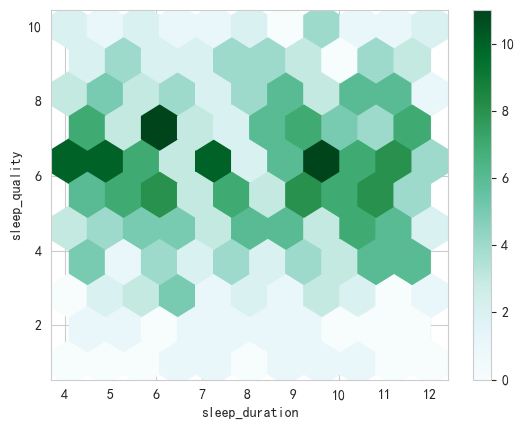

In [12]:
df.plot.hexbin(x="sleep_duration", y="sleep_quality", gridsize=10)

# 堆叠图

C:\Users\Administrator\AppData\Local\Temp\ipykernel_26856\1106005973.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_pivot_table = df.pivot_table(


<Axes: xlabel='sleep_quality_stage'>

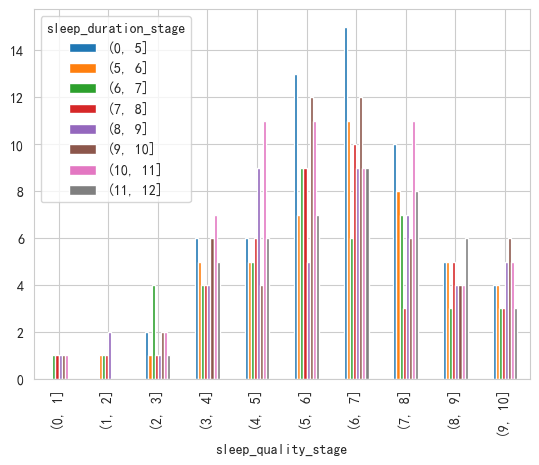

In [13]:
df["sleep_quality_stage"] = pd.cut(df["sleep_quality"], range(11))
df["sleep_duration_stage"] = pd.cut(df["sleep_duration"], [0, 5, 6, 7, 8, 9, 10, 11, 12])
df_pivot_table = df.pivot_table(
    values="person_id", index="sleep_quality_stage", columns="sleep_duration_stage", aggfunc="count"
)
df_pivot_table.plot.bar()


# 柱体堆叠

<Axes: xlabel='sleep_quality_stage'>

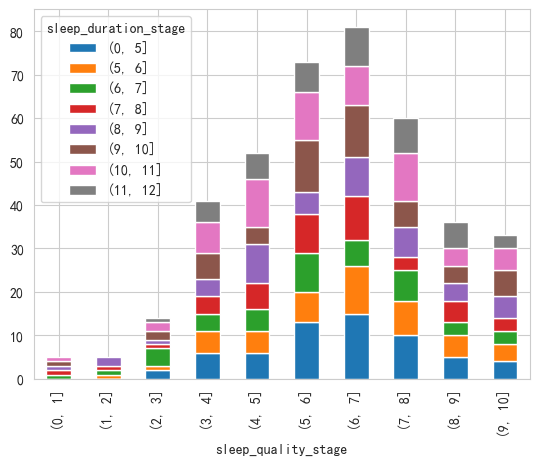

In [14]:
df_pivot_table.plot.bar(stacked=True)

# 多折线图

<Axes: xlabel='sleep_quality_stage'>

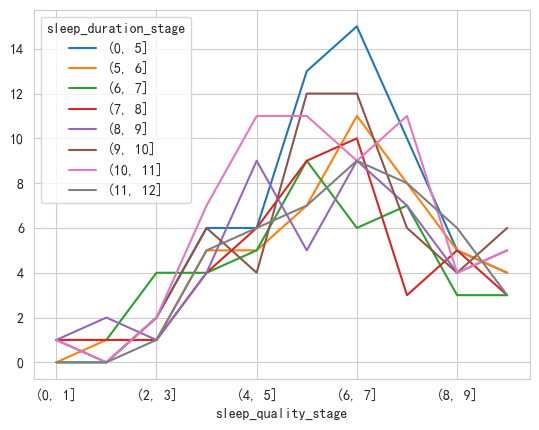

In [15]:
df_pivot_table.plot.line()

# Seaborn高级图感

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["font.sans-serif"] = ["KaiTi"]
penguins = pd.read_csv("data/penguins.csv")
penguins.dropna(inplace=True)
penguins.info()



<class 'pandas.core.frame.DataFrame'>
Index: 333 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            333 non-null    object 
 1   island             333 non-null    object 
 2   bill_length_mm     333 non-null    float64
 3   bill_depth_mm      333 non-null    float64
 4   flipper_length_mm  333 non-null    float64
 5   body_mass_g        333 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 20.8+ KB


# 1）直方图

<Axes: xlabel='species', ylabel='Count'>

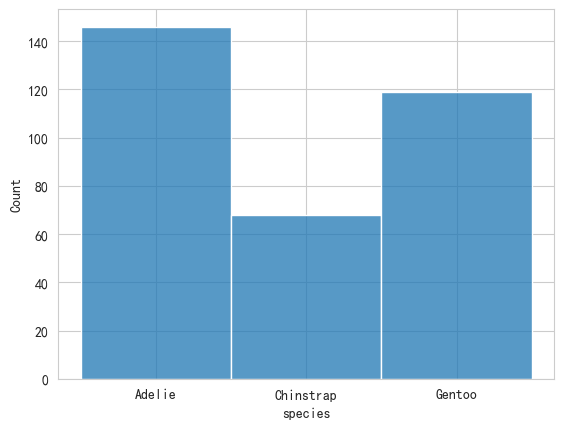

In [17]:
sns.histplot(data=penguins, x="species")

# 2）核密度估计图

<Axes: xlabel='bill_length_mm', ylabel='Density'>

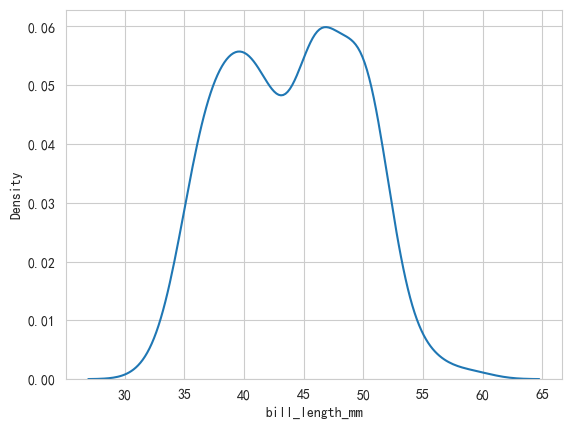

In [18]:
# 绘制喙长度的核密度估计图
sns.kdeplot(data=penguins, x="bill_length_mm")

<Axes: xlabel='bill_length_mm', ylabel='Count'>

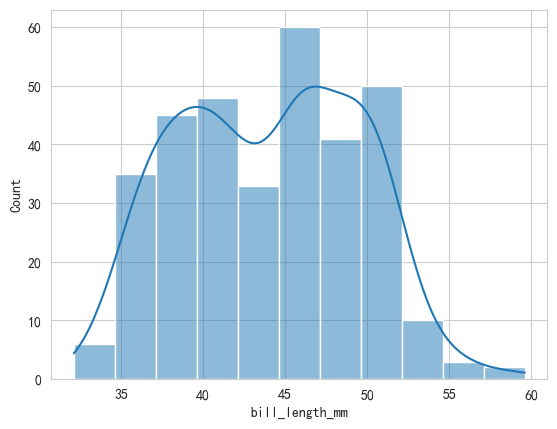

In [19]:
#在histplot()中设置kde=True也可以得到核密度估计图。
sns.histplot(data=penguins, x="bill_length_mm", kde=True)

# 3）计数图

<Axes: xlabel='island', ylabel='count'>

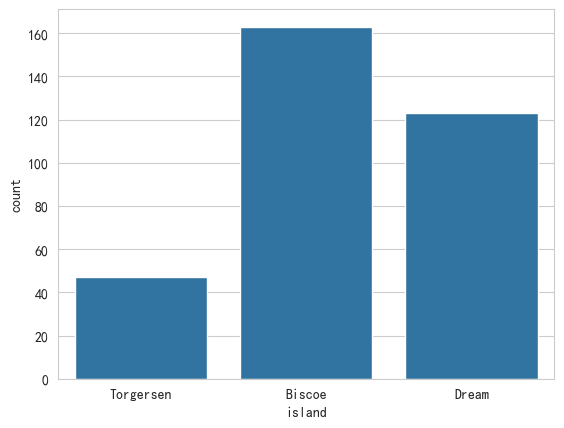

In [20]:
sns.countplot(data=penguins, x="island")

# 4 双变量可视化

<Axes: xlabel='body_mass_g', ylabel='flipper_length_mm'>

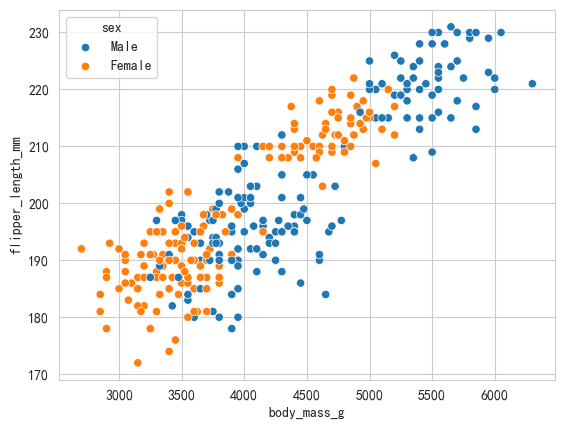

In [21]:
# 散点图
sns.scatterplot(data=penguins, x="body_mass_g", y="flipper_length_mm", hue="sex")

<Axes: xlabel='body_mass_g', ylabel='flipper_length_mm'>

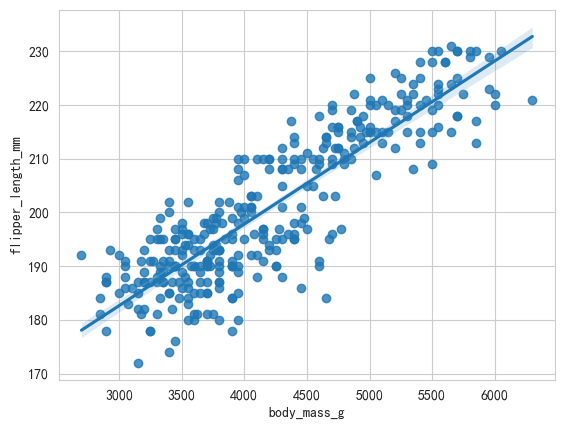

In [22]:
# 带回归曲线
sns.regplot(data=penguins, x="body_mass_g", y="flipper_length_mm")

# 4.1)多回归线

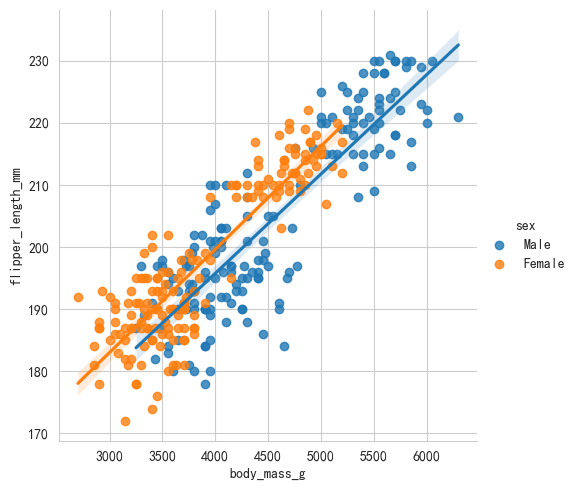

In [23]:

sns.lmplot(data=penguins, x="body_mass_g", y="flipper_length_mm", hue="sex")

# 4.2带频率的散点图

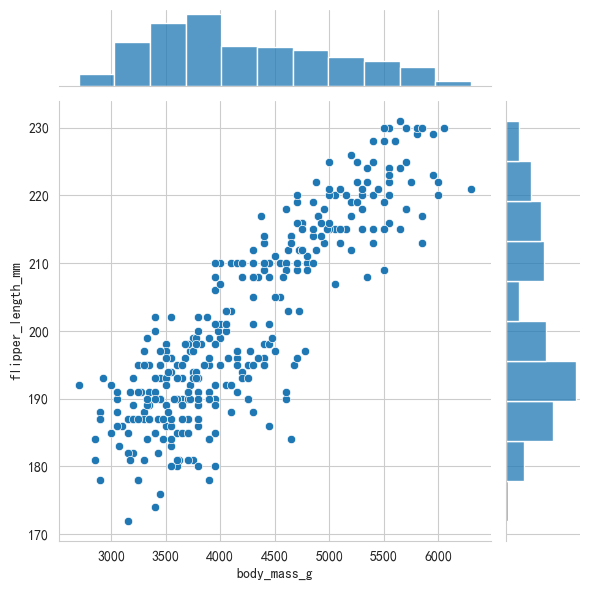

In [24]:
sns.jointplot(data=penguins, x="body_mass_g", y="flipper_length_mm")

# 4.3蜂窝图

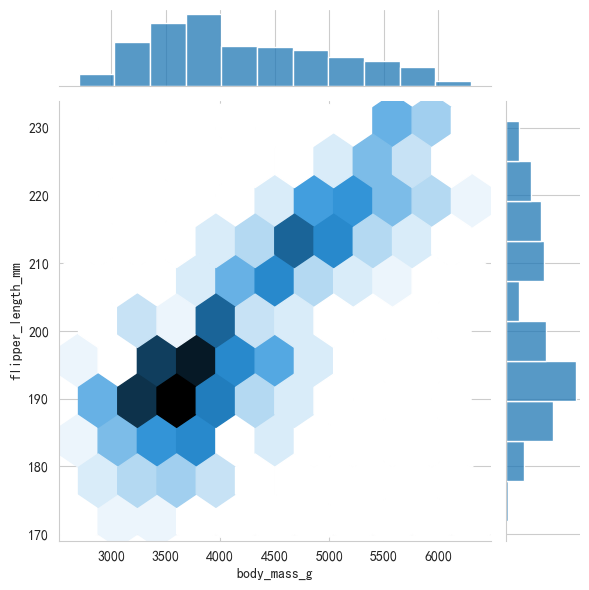

In [25]:
sns.jointplot(data=penguins, x="body_mass_g", y="flipper_length_mm", kind="hex")

# 4.4二维核密度估计图

<Axes: xlabel='body_mass_g', ylabel='flipper_length_mm'>

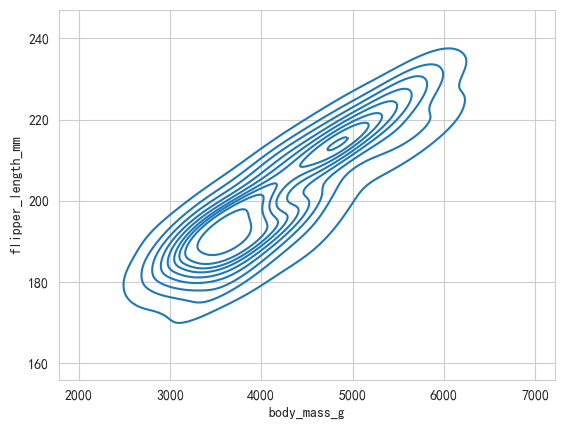

In [26]:
sns.kdeplot(data=penguins, x="body_mass_g", y="flipper_length_mm")

<Axes: xlabel='body_mass_g', ylabel='flipper_length_mm'>

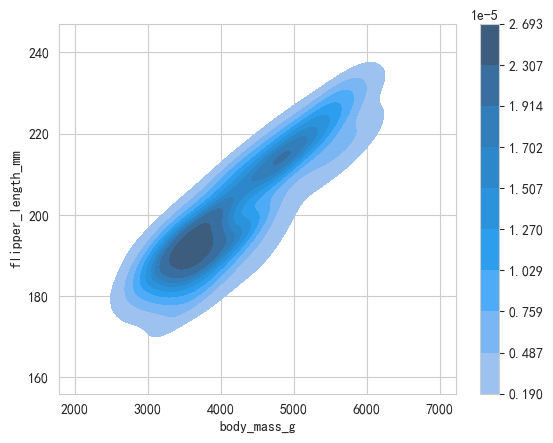

In [27]:
sns.kdeplot(data=penguins, x="body_mass_g", y="flipper_length_mm", fill=True, cbar=True)

# 4.5条形图

<Axes: xlabel='species', ylabel='bill_length_mm'>

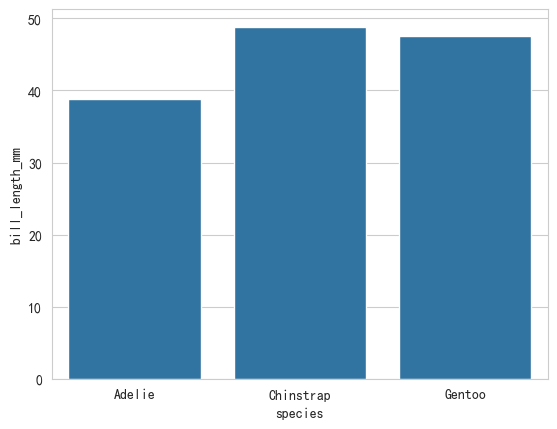

In [28]:
sns.barplot(data=penguins, x="species", y="bill_length_mm", estimator="mean", errorbar=None)

# 4.6箱线图

<Axes: xlabel='species', ylabel='bill_length_mm'>

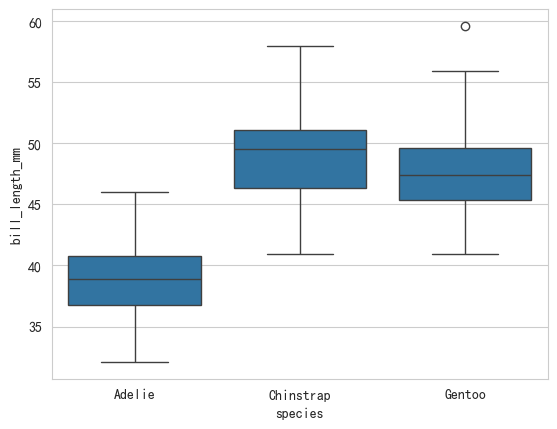

In [29]:
sns.boxplot(data=penguins, x="species", y="bill_length_mm")

# 4.7小提琴图

<Axes: xlabel='species', ylabel='bill_length_mm'>

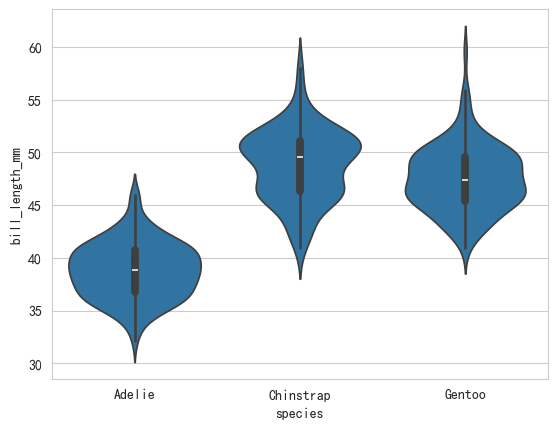

In [30]:
sns.violinplot(data=penguins, x="species", y="bill_length_mm")

# 4.8成对关系图

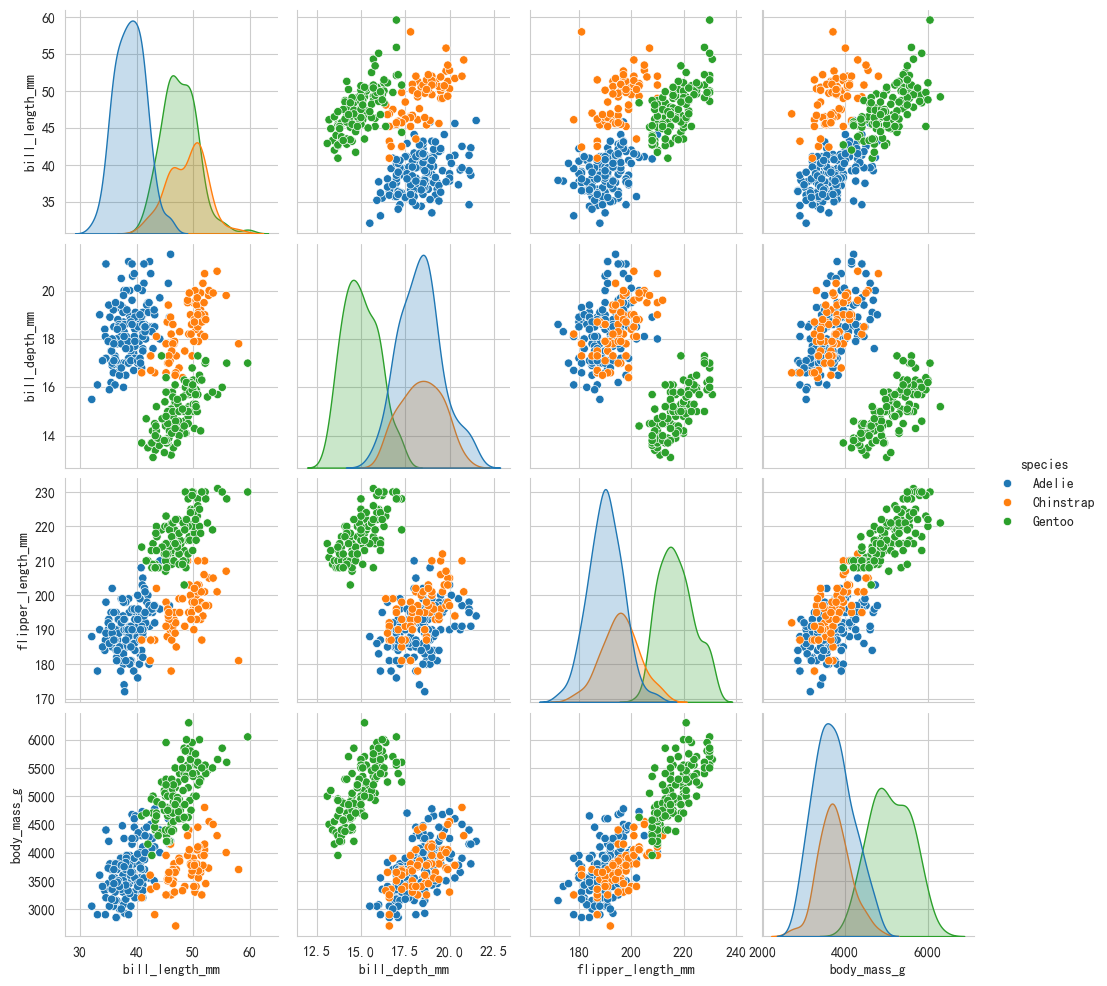

In [31]:
sns.pairplot(data=penguins, hue="species")

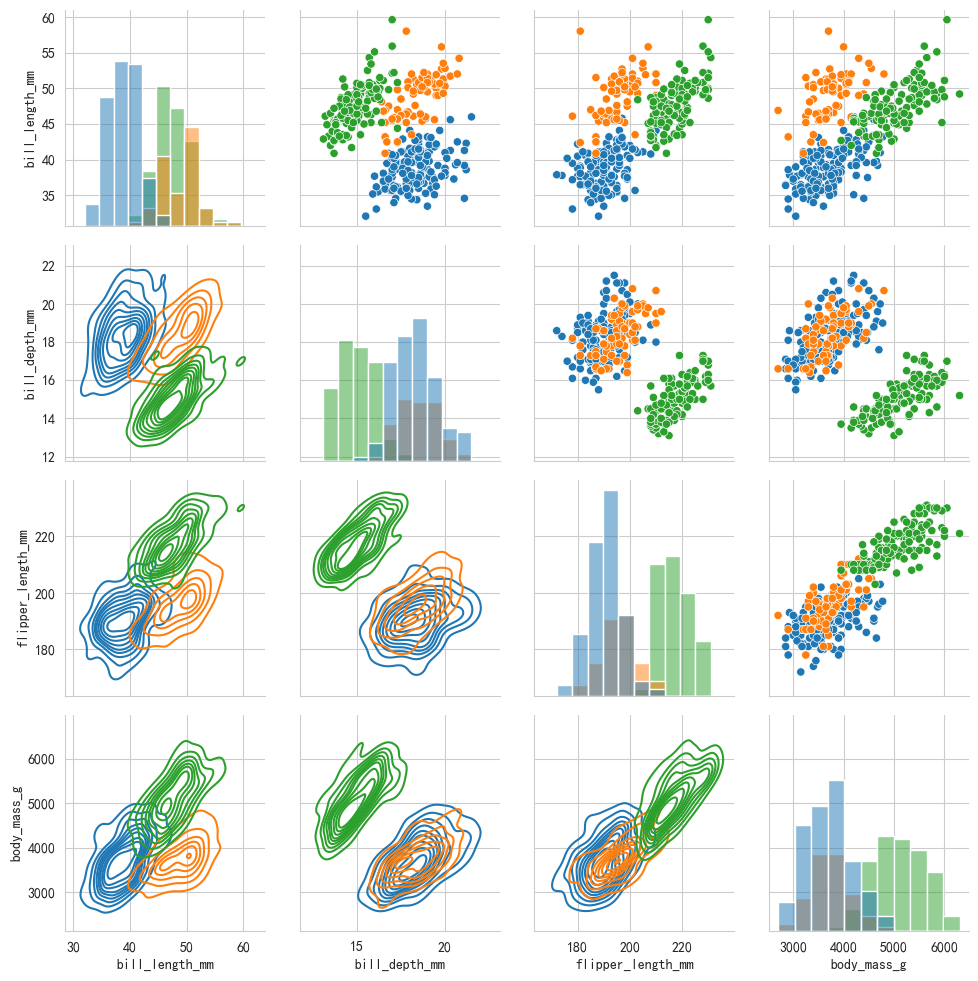

In [32]:
#通常情况下成对关系图左上和右下对应位置的图的信息是相同的，可以通过PairGrid()为每个区域设置不同的图类型。
pair_grid = sns.PairGrid(data=penguins, hue="species")

# 通过 map 方法在网格上绘制不同的图形
pair_grid.map_upper(sns.scatterplot)  # 上三角部分使用散点图
pair_grid.map_lower(sns.kdeplot)  # 下三角部分使用核密度估计图
pair_grid.map_diag(sns.histplot)  # 对角线部分使用直方图


# 5多变量可视化

<Axes: xlabel='species', ylabel='bill_length_mm'>

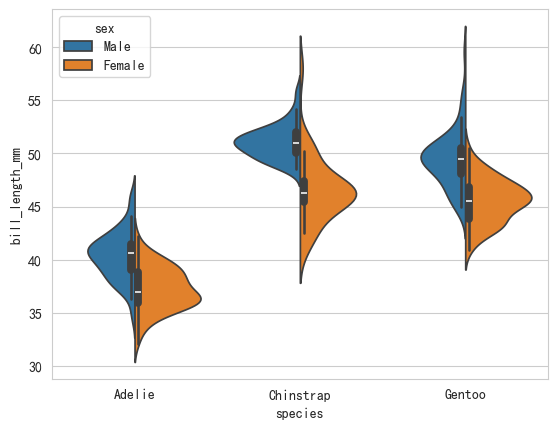

In [33]:
sns.violinplot(data=penguins, x="species", y="bill_length_mm", hue="sex", split=True)

# 6皮尔森系数

TV           0.782224
Radio        0.576223
Newspaper    0.228299
dtype: float64


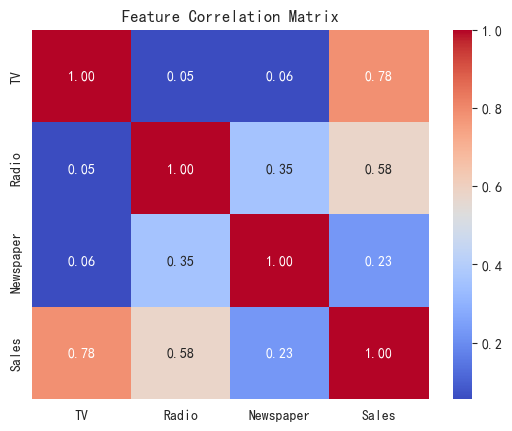

In [34]:
import pandas as pd

advertising = pd.read_csv("data/advertising.csv")
advertising.drop(advertising.columns[0], axis=1, inplace=True)
advertising.dropna(inplace=True)
X = advertising.drop("Sales", axis=1)
y = advertising["Sales"]
# 计算皮尔逊相关系数
print(X.corrwith(y, method="pearson"))

import seaborn as sns
import matplotlib.pyplot as plt

# 计算皮尔逊相关系数矩阵
corr_matrix = advertising.corr(method="pearson")
# 可视化热力图
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()
